In [14]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import f1_score
import os
import tensorflow as tf
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import Dense , Flatten, Conv2D, MaxPooling2D, Dropout, Input , BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

In [15]:
label = [] 
path = [] 
fish_dir = './data/dataset'
for dir_name , _,filenames in os.walk(fish_dir): # name of the directory, name of the directories contained in the main directory, names of the files contained in the main directory
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))

In [16]:
df = pd.DataFrame(columns=["path","label"])
df["path"] = path
df["label"] = label

In [17]:
df.head()

,path,label
0,./data/dataset\abomasnow\abomasnow_1.png,abomasnow
1,./data/dataset\abomasnow\abomasnow_10.png,abomasnow
2,./data/dataset\abomasnow\abomasnow_11.png,abomasnow
3,./data/dataset\abomasnow\abomasnow_12.png,abomasnow
4,./data/dataset\abomasnow\abomasnow_13.png,abomasnow


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 entries, 0 to 26538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    26539 non-null  object
 1   label   26539 non-null  object
dtypes: object(2)
memory usage: 414.8+ KB


In [19]:
df.nunique()

path     26539
label     1000
dtype: int64

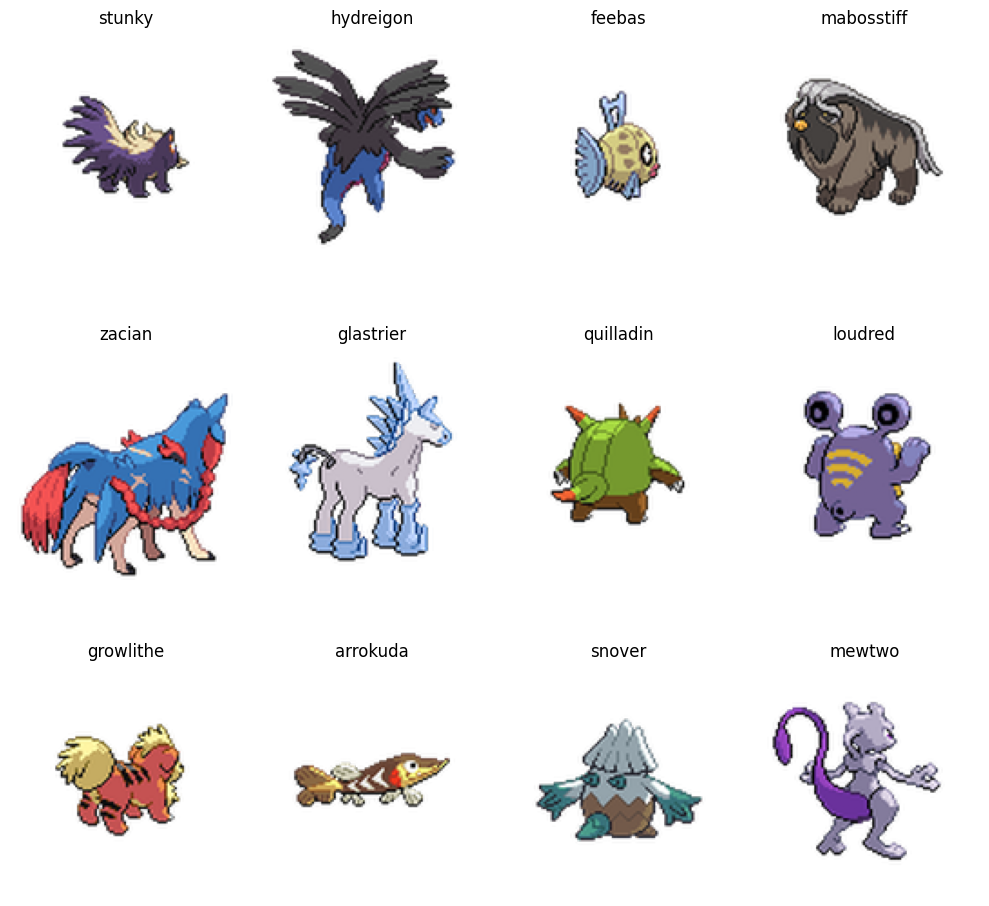

In [34]:
random_labels = random.sample(list(df['label'].unique()), 12) #returns 12 random element of the list : list(df['label'].unique())

plt.figure(figsize=(10, 10))
for idx, label in enumerate(random_labels): # method to get the index and the element of the list at the same time
    plt.subplot(3, 4, idx + 1) # nb_rows, nb_cols, idx associated with the subplots that we are modifying (1 is on the top-left)
    image_path = df[df['label'] == label].iloc[0, 0] # always taking the first image 
    plt.imshow(plt.imread(image_path)) # method to display an image with plt
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
from PIL import Image

random_images = random.sample(list(df['path']), 1000) # taking a sample of 1000 random images

image_sizes = []

for img_path in random_images:
    with Image.open(img_path) as img: # useful to get properties of the image
        image_sizes.append(img.size) 

widths, heights = zip(*image_sizes)
average_size = (int(sum(widths) / len(widths)), int(sum(heights) / len(heights)))

print(f"The average size of a sample of 1000 images is : {average_size}")

The average size of a sample of 1000 images is : (128, 128)


In [ ]:
labels = df['label'].astype('category').cat.codes # encoding the different classes as 0, 1, 2, 3, ..., 999
df['label_encoded'] = labels

img_size = (128, 128)

images = []
for img_path in df['path']:
    img = load_img(img_path, target_size=img_size) # loads the image from the specified path and resize it at "target_size"
    img_array = img_to_array(img) / 255 # converts the img to an array (shape is (128, 128, 3)) and normalize it to put the value between 0 and 1
    images.append(img_array)

X = np.array(images)
y = to_categorical(df['label_encoded']) # convert each row of y to a one-hot vector, it means that if df['label_encoded'] == 192, the idx 192 of y will be equals to 1 in this row. y verify automatically the number of unique class, and the one-hot vector's length corresponds to this number.  

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [53]:
print(f"X Train Shape : {X_train.shape}\nX Test Shape : {X_test.shape}\nY Train Shape : {y_train.shape}\nY Test Shape : {y_test.shape}")

X Train Shape : (18577, 128, 128, 3)
X Test Shape : (7962, 128, 128, 3)
Y Train Shape : (18577, 1000)
Y Test Shape : (7962, 1000)


In [58]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) # get the idx of the maximum of y_test, to correspond to the initial label.

In [60]:
y_test

array([483, 420, 289, ..., 442,  46, 585], dtype=int64)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
) # computing the class weight in order to make our model working as if we had a balanced proportion of all the classes, so we avoid issue with imbalanced

class_weights_dict = dict(enumerate(class_weights))

# Les poids modifient la contribution de chaque classe à la perte totale. Les classes moins fréquentes, ayant des poids plus élevés, contribuent davantage à la perte, ce qui force le modèle à prêter plus d'attention à ces classes pendant l'entraînement.

In [64]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    base_model,  
    GlobalAveragePooling2D(), 
    BatchNormalization(),
    Dense(256, activation='relu', name="Layer1"),
    BatchNormalization(),
    Dropout(0.5), 
    Dense(128, activation='relu', name="Layer2"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1000, activation='softmax', name="output_layer")
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'val_accuracy'])

In [66]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True  
)

In [ ]:
def image_generator(X, y, batch_size, class_weights): # generation of different batches associated with the weight of each class, idk why he does that manually, I think that keras has method that already do that
    while True:
        
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            sample_weights = np.array([class_weights.get(label, 1.0) for label in y_batch])

            yield X_batch, y_batch, sample_weights

In [70]:
history = model.fit(
    image_generator(X_train, y_train, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(X_train) // 128,  
    epochs=15,
    validation_data=image_generator(X_test, y_test, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(X_test) // 128   
)

Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 516s 3s/step - accuracy: 0.0043 - loss: 6.9411 - val_accuracy: 6.3004e-04 - val_loss: 7.5511
Epoch 2/15
  9/145 ━━━━━━━━━━━━━━━━━━━━ 6:21 3s/step - accuracy: 0.0196 - loss: 6.5258

KeyboardInterrupt: 

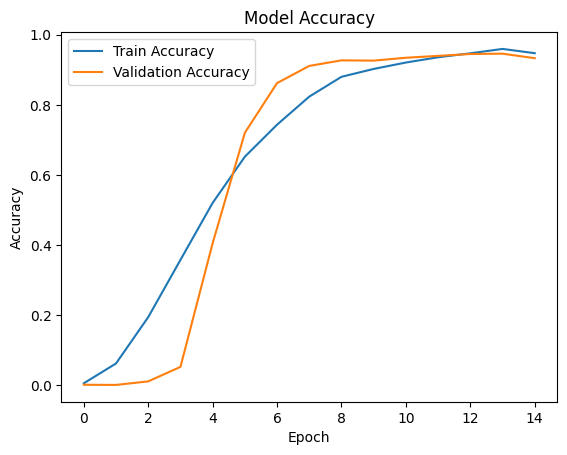

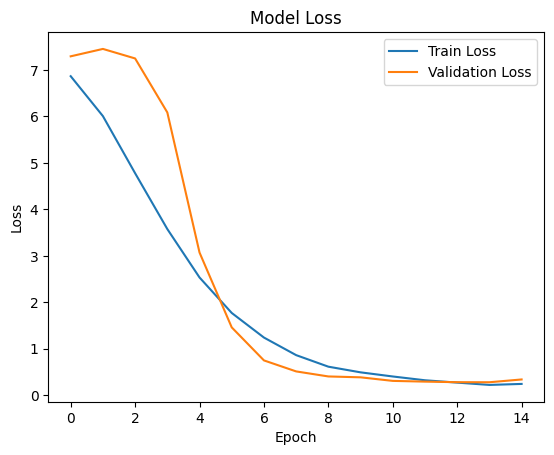

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
results = model.evaluate(X_test, y_test)
test_loss, test_accuracy = results[0], results[1]
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9322 - loss: 0.2928
Test Loss: 0.2834
Test Accuracy: 0.9332


In [21]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step
Weighted Average F1 Score: 0.9336


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


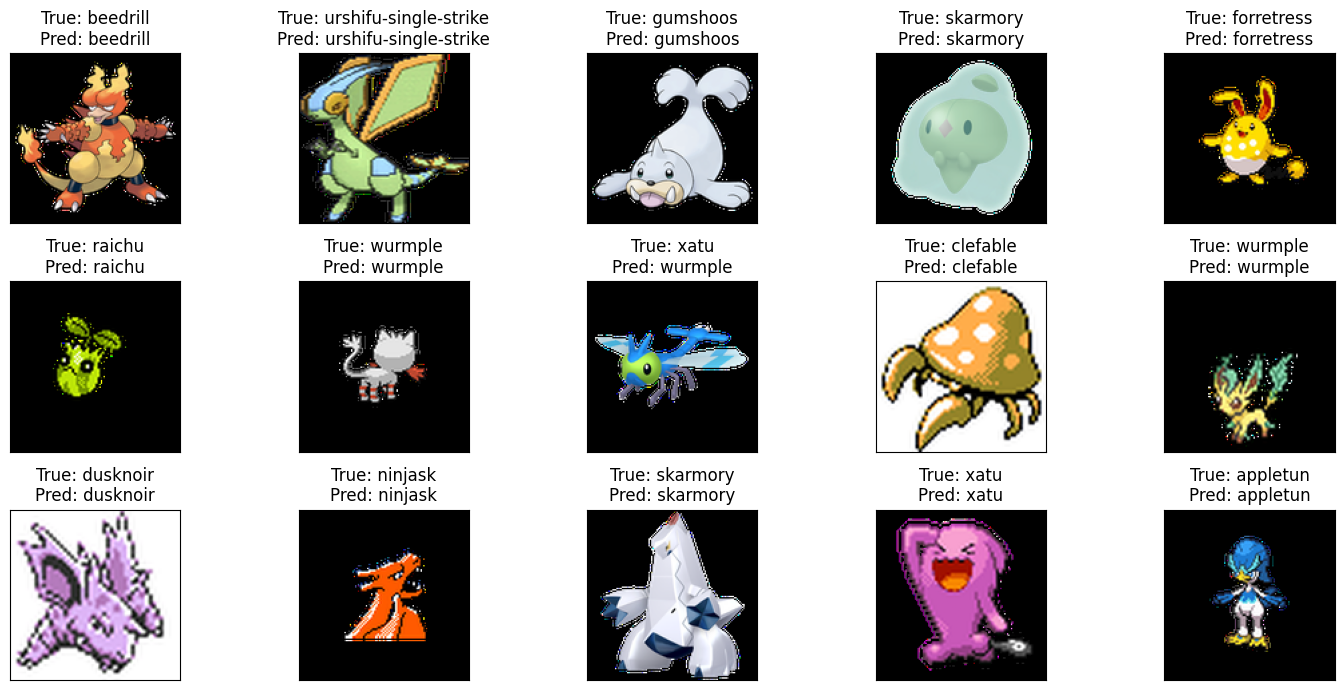

In [22]:
num_images = 15
indices = np.random.choice(len(X_test), num_images, replace=False)
selected_images = X_test[indices]
true_labels = y_test[indices]
predicted_labels = np.argmax(model.predict(selected_images), axis=1)


pokemon_names = df["label"].values 

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = selected_images[i]
    if img.shape[-1] == 1: 
        img = img.squeeze(-1)
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    
    true_pokemon = pokemon_names[true_labels[i]]  
    predicted_pokemon = pokemon_names[predicted_labels[i]]
    ax.set_title(f"True: {true_pokemon}\nPred: {predicted_pokemon}")

plt.tight_layout()
plt.show()